In [2]:
from netCDF4 import Dataset
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import shapefile

In [2]:
folder = os.path.expanduser('~/Documents/data/oscar/')
filename = folder + 'oscar_vel2000.nc'
nc = Dataset(filename)
t = nc.variables['time'][:]
lon = nc.variables['longitude'][:]
lat = nc.variables['latitude'][:]
depth = nc.variables['depth'][:] # 15m because average of 0-30m
u = nc.variables['u'][:].squeeze()
v = nc.variables['v'][:].squeeze()

# convert masked array to regular array
mask = np.ma.getmask(u)
u = np.ma.getdata(u)
v = np.ma.getdata(v)

# longitude is giving from 20-420 (seriously, who thought this is a good idea)
# let's change this to [0, 360]
i0 = 0 # 20 deg
i1 = np.argmin((180 - lon) ** 2)
i2 = np.argmin((360 - lon) ** 2)
i3 = np.argmin((380 - lon) ** 2)
lon = np.concatenate((lon[i1+1:i2], lon[i2:i3]-360, lon[i0:i1+1]))

# first velocity field
u = u[0]
v = v[0]

u = np.hstack((u[:,i1+1:i2], u[:, i2:i3], u[:,i0:i1+1]))
v = np.hstack((v[:,i1+1:i2], v[:, i2:i3], v[:,i0:i1+1]))

def wrap_to_360(lon):
    """Convert longitude array from [-180, 180] to [0, 360]"""
    return lon % 360

def wrap_to_180(lon):
    """Convert longitude array from [0, 360] to [-180, 180]"""
    switch = np.logical_or(lon < -180, 180 < lon)
    lon[switch] = wrap_to_360(lon[switch] + 180) - 180
    return lon

# then just change lon to [-180, 180]
lon = wrap_to_180(lon)

/Users/pmiron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/pmiron/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


### The boundaries of the oceans and seas and plot using a digital high-resolution map 

I used a shapefile from the paper, A New Digital Map of Limits of Oceans and Seas Consistent with High-Resolution Global Shorelines (see citation) freely available https://www6.rennes.inra.fr/ese_eng/Media/Fichier/HRMLOS-shapfile.


Fourcy, D. and Lorvelec, O., 2013. A new digital map of limits of oceans and seas consistent with high-resolution global shorelines. Journal of Coastal Research, 29(2), 471-477. DOI:10.2112/JCOASTRES-D-12-00079.1

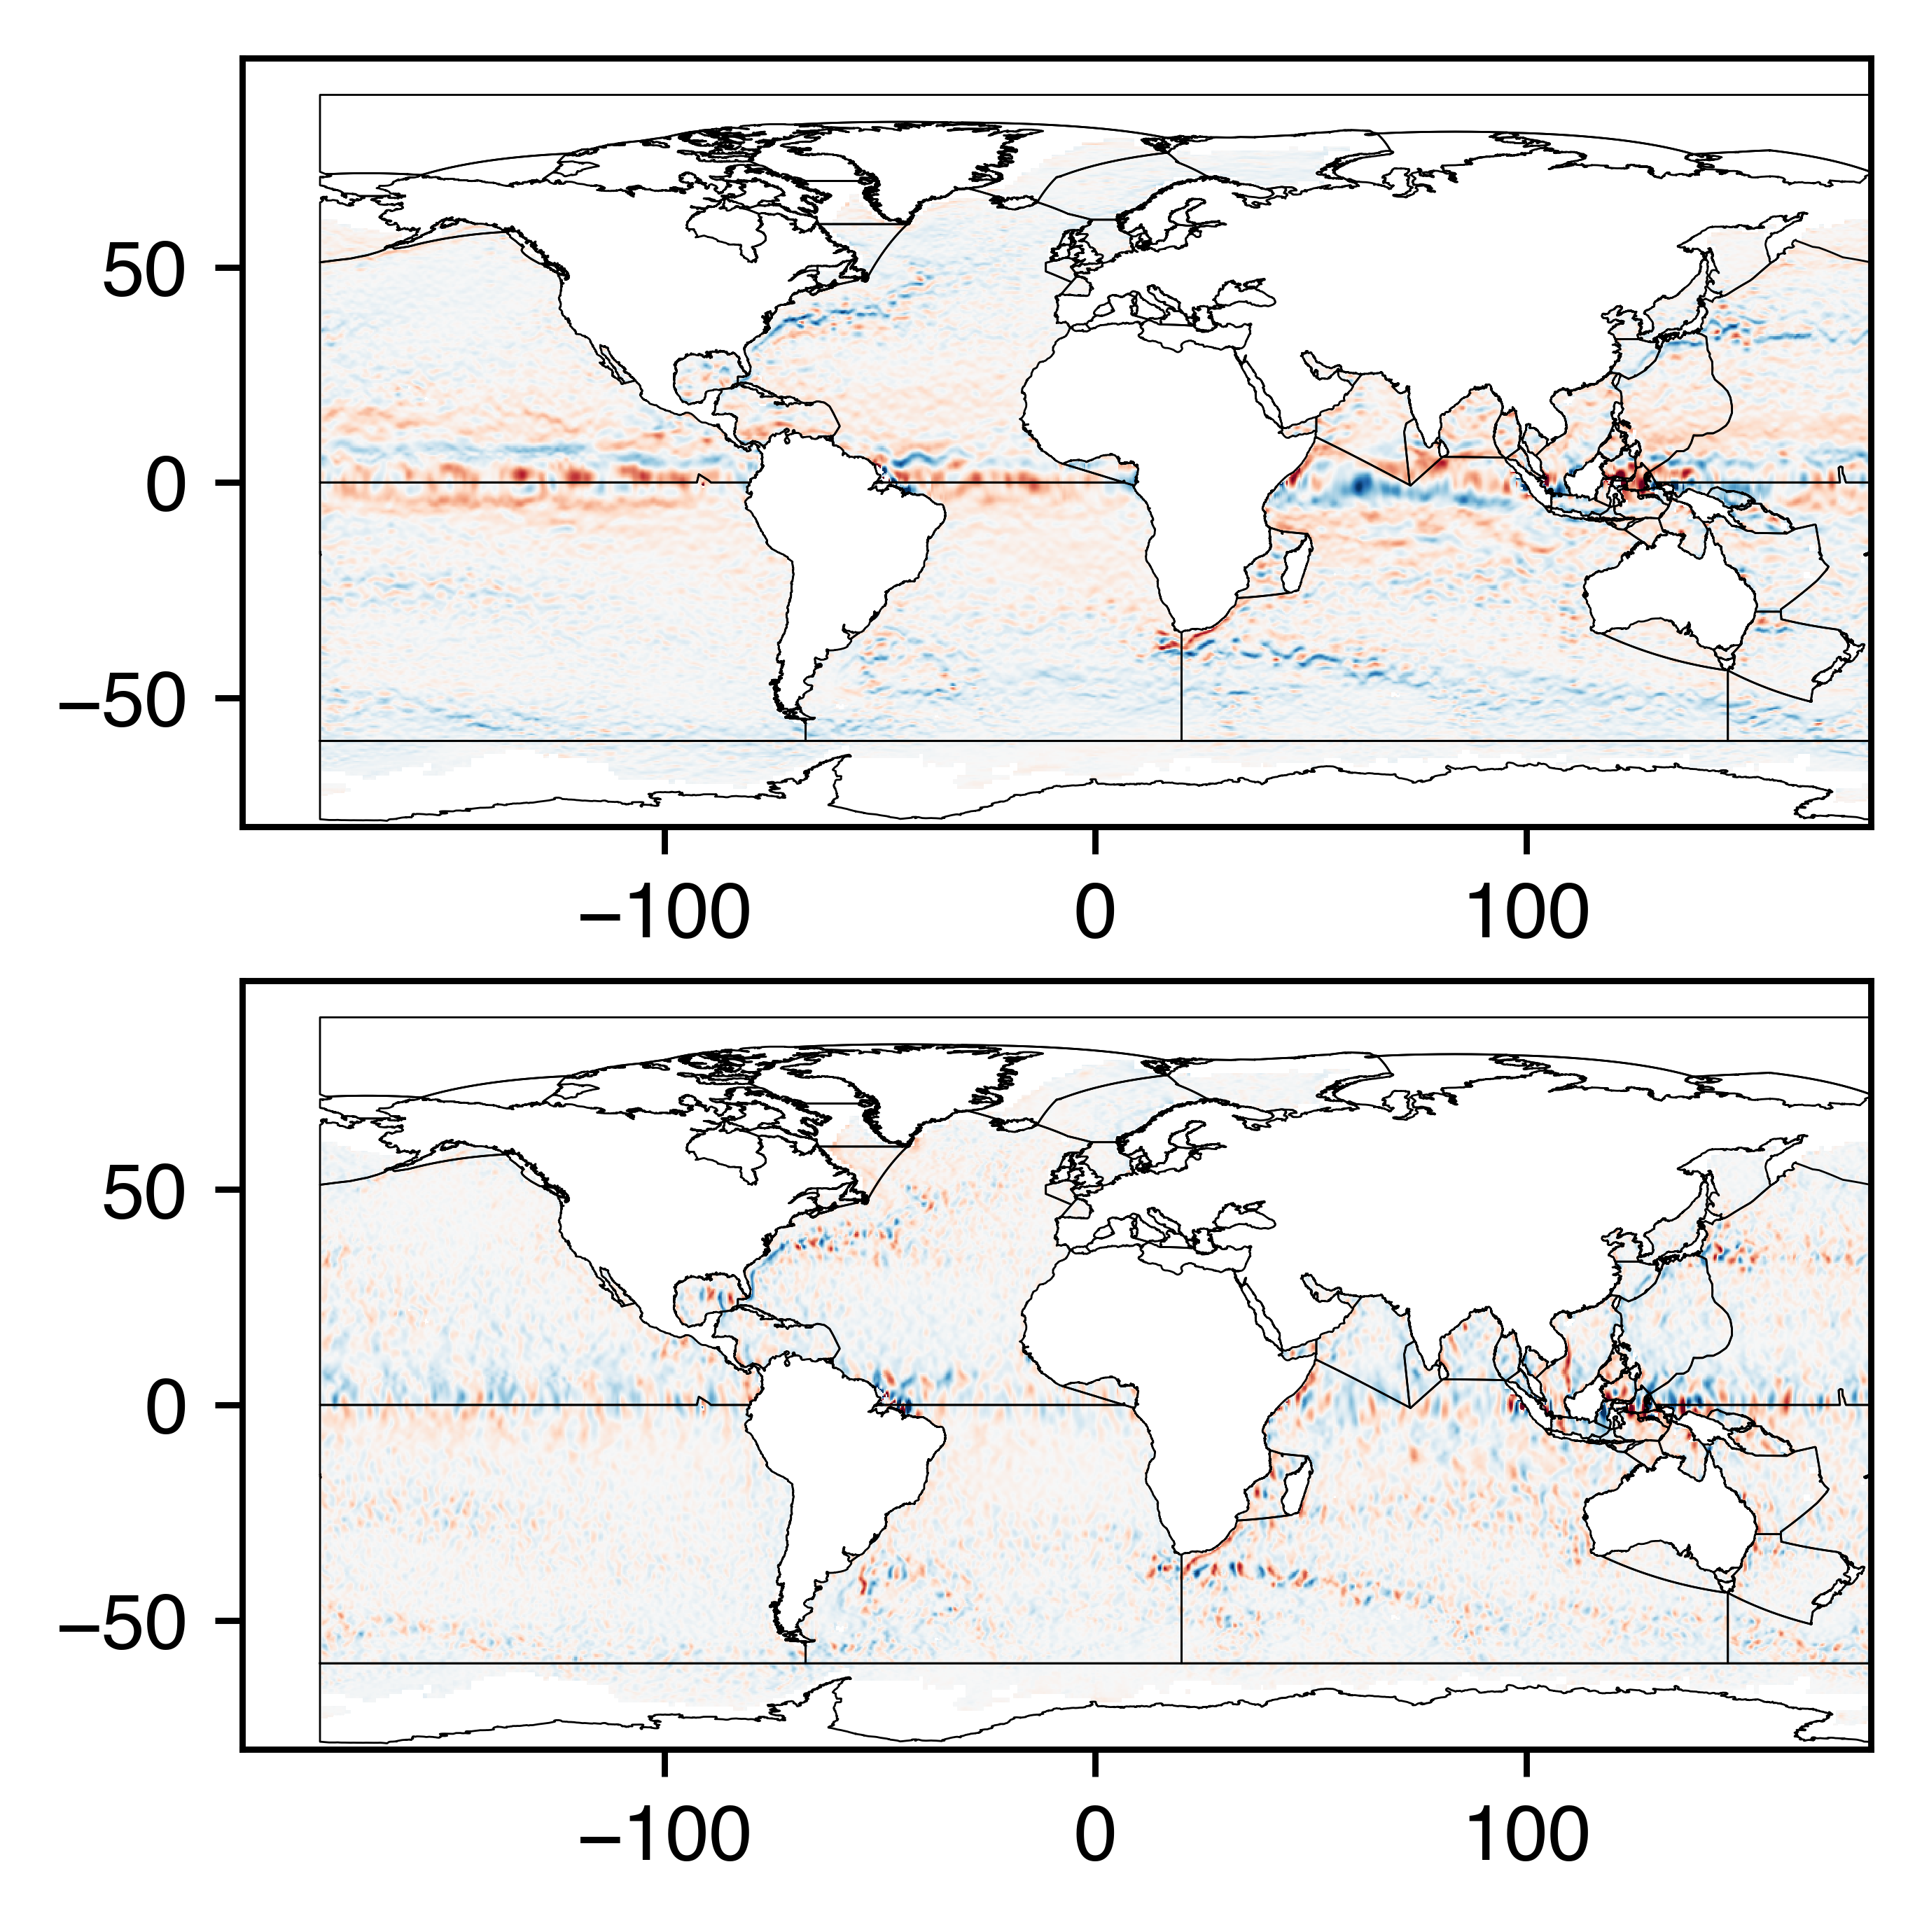

In [4]:
width = 6
fig = plt.figure(dpi=800)
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

ax1.pcolormesh(lon, lat, u, cmap='RdBu', vmin=-1.25, vmax=1.25)
ax2.pcolormesh(lon, lat, v, cmap='RdBu', vmin=-1.25, vmax=1.25)
ax1.set_aspect('equal')
ax2.set_aspect('equal')

# get the file and put it in the right folder
shape_folder = os.path.expanduser('~/Documents/data/boundaries/oceans/')
shape = shapefile.Reader(shape_folder + 'HRmLOS_1.1.shp')
# plot oceans boundaries
d = {'Indian Ocean': 29, 'South Atlantic Ocean':24, 'North Atlantic Ocean':93, 
              'South Pacific Ocean':22, 'North Pacific Ocean':73, 'Southern Ocean':0, 'Arctic Ocean':104}
#for key, value in d.items():
for value in range(0, shape.numRecords):
    feature = shape.shapeRecord(value)
    parts = feature.shape.parts
    pts = feature.shape.points
    pts = np.array(pts)

    # keep only the largest parts except for the South/North Pacific Ocean
    # where we have the keep the 2 largest because it is splitted in two
    if feature.record[0] == 'South Pacific Ocean' or feature.record[0] == 'North Pacific Ocean':
        large_parts = np.argpartition(np.diff(feature.shape.parts), -2)[-2:]
    else:
        large_parts = [np.argmax(np.diff(feature.shape.parts))]

    for i in large_parts:
        prange = np.arange(parts[i], parts[i+1]-1)
        ax1.plot(pts[prange,0], pts[prange,1], 'k', linewidth=0.25)
        ax2.plot(pts[prange,0], pts[prange,1], 'k', linewidth=0.25)

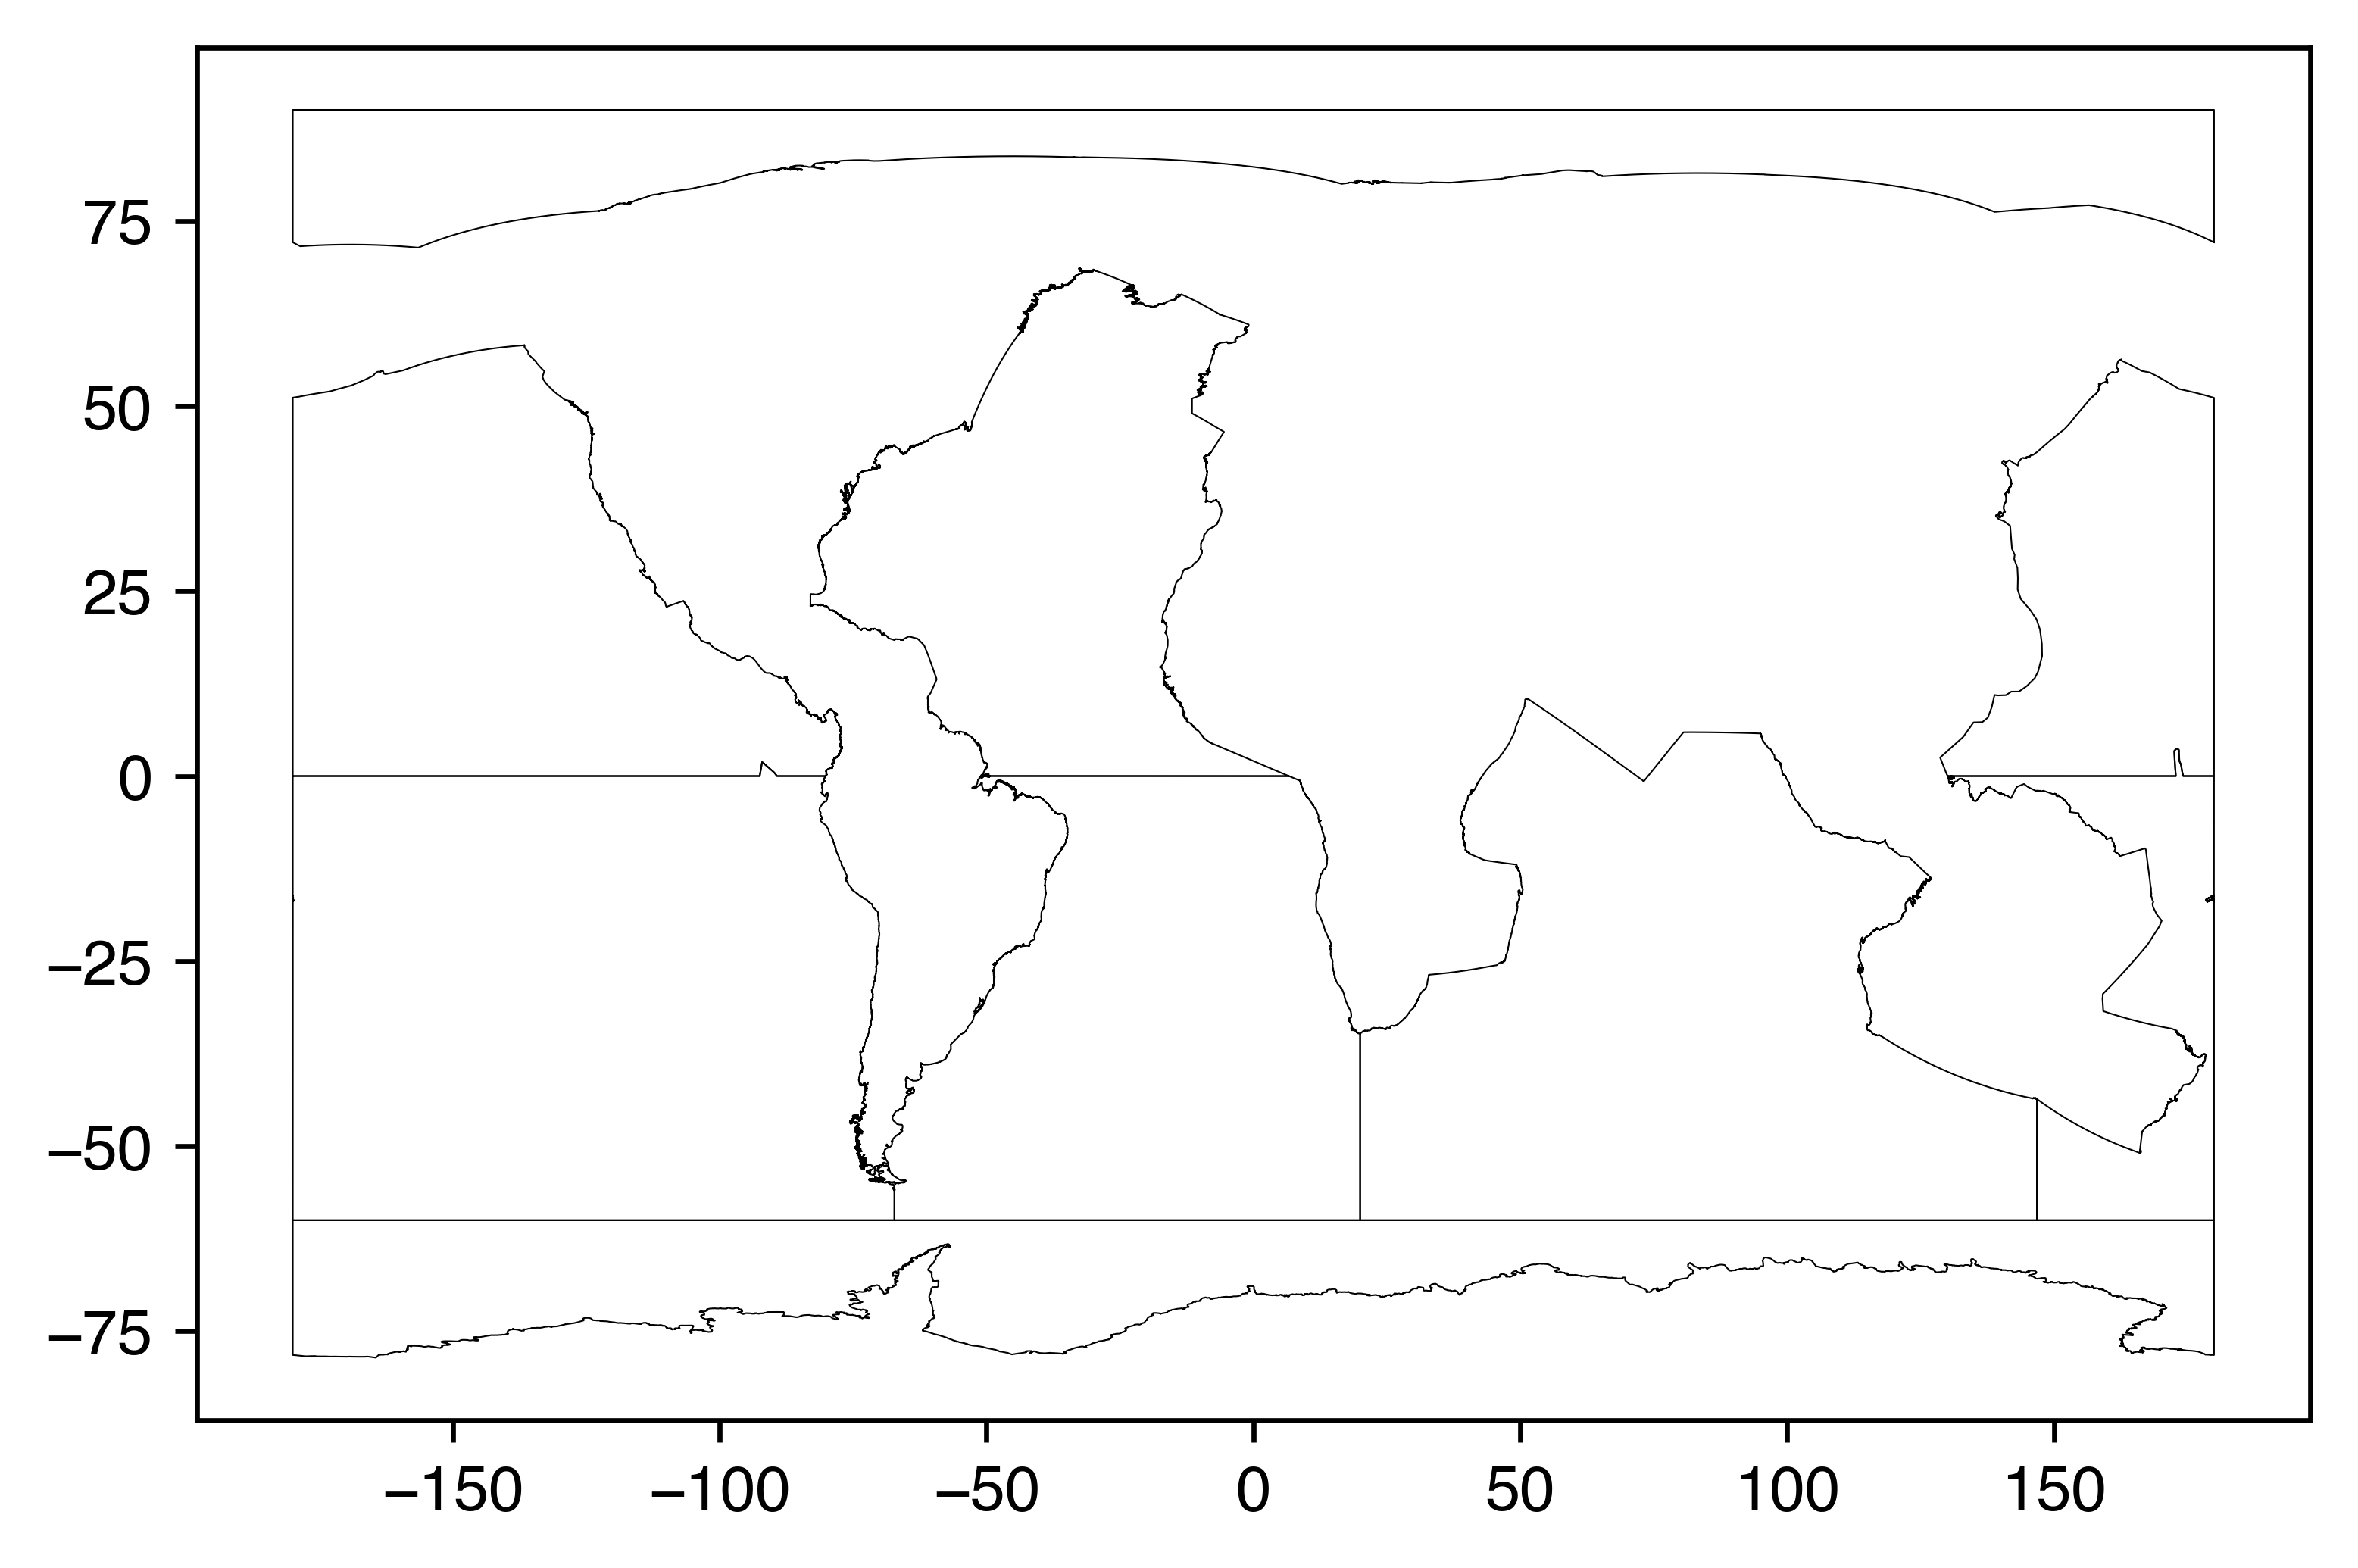

In [6]:
# plot of just the ocean boundaries
shape_folder = os.path.expanduser('~/Documents/data/boundaries/oceans/')
shape = shapefile.Reader(shape_folder + 'HRmLOS_1.1.shp')

width = 6
fig = plt.figure(dpi=600)
ax1 = fig.add_subplot(1, 1, 1)

# plot only selected oceans boundaries
d = {'Indian Ocean': 29, 'South Atlantic Ocean':24, 'North Atlantic Ocean':93, 
              'South Pacific Ocean':22, 'North Pacific Ocean':73, 'Southern Ocean':0, 'Arctic Ocean':104}
for key, value in d.items():
    feature = shape.shapeRecord(value)
    parts = feature.shape.parts
    pts = feature.shape.points
    pts = np.array(pts)

    # keep only the largest parts except for the South/North Pacific Ocean
    # where we have the keep the 2 largest because it is splitted in two (at the +-180°)
    if feature.record[0] == 'South Pacific Ocean' or feature.record[0] == 'North Pacific Ocean':
        large_parts = np.argpartition(np.diff(feature.shape.parts), -2)[-2:]
    else:
        large_parts = [np.argmax(np.diff(feature.shape.parts))]

    for i in large_parts:
        prange = np.arange(parts[i], parts[i+1]-1)
        ax1.plot(pts[prange,0], pts[prange,1], 'k', linewidth=0.25)